In [15]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## 🎈파라미터

In [16]:
# 일정한 시간 간격으로 음압을 측정하는 주파수, 22050Hz
hp_sample_rate = 22050

# -- wav 길이가 다양하기 때문에, 길면 자르고 짧으면 padding 붙여서 일정하게 조절.
# -- 잘린 wav가 0.1sec~0.3sec이니까 20(0.2sec~0.3sec)으로 결정
max_pad_len = 20

# -- return 될 mfcc의 개수
n_mfcc_feature = 40

# -- model input shape
n_row = n_mfcc_feature    
n_columns = max_pad_len    
n_channels = 1

# -- 구분할 class 개수 4개
# -- CC : 0, HH : 1, KK : 2, SD : 3
n_classes = 4

## ✨ Drum Mapping

In [17]:
"""
CC : 0
HH : 1
KK : 2
SD : 3
"""

drum2code = {'CC':0, 'HH':1, 'KK':2, 'SD':3}
code2drum = {0:'CC', 1:'HH', 2:'KK', 3:'SD'} 

## 🎈 feature 추출

In [18]:
root = "../data/tmp_test_wavs/"
test = root + "SD_16_0001_0003.wav"

def extract_feature(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, sr=hp_sample_rate, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc_feature)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0,0), (0, pad_width)), mode='constant')
        print('file name :', file_name, ', length:', audio.shape[0]/float(sample_rate), 'secs, ', 'mfccs:', mfccs.shape)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e)
        return None
    return mfccs

extract_feature(test)

file name : ../data/tmp_test_wavs/SD_16_0001_0003.wav , length: 0.1 secs,  mfccs: (40, 20)


array([[-5.27414780e+01, -3.01314163e+01, -6.14640503e+01,
        -8.79343719e+01, -1.25006866e+02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 9.34141617e+01,  8.40933838e+01,  6.60681610e+01,
         7.19200897e+01,  8.24611130e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 7.53938913e+00, -4.91775608e+00, -2.28326759e+01,
        -1.50874014e+01, -2.15845490e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0

## 🎈 Data 가져와서 feature 추출

In [19]:
# -- onset 잘린 per drum data folder path
root_path = "../data/trimmed_per_drum_wavs/"
wav_list = os.listdir(root_path)
wav_files = [os.path.join(root_path, file) for file in wav_list if file.endswith('.wav')]
print(len(wav_files))

data = []
for wav_file in wav_files:
    # -- feature: mfcc
    feature = extract_feature(wav_file)
    
    # -- class_label: 드럼 종류
    file_name = os.path.basename(wav_file)
    class_label = drum2code[file_name[:2]]
    data.append([feature, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(data, columns=['feature','class_label'])

3878
file name : ../data/trimmed_per_drum_wavs/CC_04_9949_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9949_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9949_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9949_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9950_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9950_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9950_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9950_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9951_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9951_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file 

file name : ../data/trimmed_per_drum_wavs/CC_04_9952_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9952_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9952_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9952_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9953_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9953_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9953_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9953_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9954_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9954_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name 

/home/jaeserrr/anaconda3/envs/drum/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1483
  warnings.warn(


file name : ../data/trimmed_per_drum_wavs/CC_04_9972_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9972_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9972_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9972_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9973_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9973_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9973_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9973_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9974_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9974_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name 

/home/jaeserrr/anaconda3/envs/drum/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1888
  warnings.warn(


file name : ../data/trimmed_per_drum_wavs/CC_04_9995_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9996_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9996_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9996_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9996_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9997_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9997_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9997_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9997_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_04_9998_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name 

/home/jaeserrr/anaconda3/envs/drum/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1793
  warnings.warn(


file name : ../data/trimmed_per_drum_wavs/CC_08_9964_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9965_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9966_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9967_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9967_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9968_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9968_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9969_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9970_0001.wav , length: 0.09287981859410431 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9970_0002.wav , length: 0.1 secs,  mfccs: (40

/home/jaeserrr/anaconda3/envs/drum/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2047
  warnings.warn(


file name : ../data/trimmed_per_drum_wavs/CC_08_9975_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9976_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9976_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9977_0001.wav , length: 0.09287981859410431 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9977_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9978_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9979_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9980_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9981_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/CC_08_9982_0001.wav , length: 0.1 secs,  mfccs: (40

/home/jaeserrr/anaconda3/envs/drum/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1792
  warnings.warn(


file name : ../data/trimmed_per_drum_wavs/CC_08_9999_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/HH_04_0001_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/HH_04_0001_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/HH_04_0001_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/HH_04_0001_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/HH_04_0002_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/HH_04_0002_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/HH_04_0002_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/HH_04_0002_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/HH_04_0003_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name 

/home/jaeserrr/anaconda3/envs/drum/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1072
  warnings.warn(


file name : ../data/trimmed_per_drum_wavs/KK_04_0013_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_04_0013_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_04_0013_0005.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_04_0014_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_04_0014_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_04_0014_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_04_0014_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_04_0015_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_04_0015_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_04_0015_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name 

/home/jaeserrr/anaconda3/envs/drum/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1339
  warnings.warn(


file name : ../data/trimmed_per_drum_wavs/KK_08_0019_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_08_0019_0005.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_08_0019_0006.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_08_0019_0007.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_08_0019_0008.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_08_0020_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_08_0020_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_08_0020_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_08_0020_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
file name : ../data/trimmed_per_drum_wavs/KK_08_0021_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
file name 

## 🎈 훈련(Train), 검증(Test) Dataset 생성

In [20]:
# -- one-hot-encoding
# 예를 들어, 자연수 1, 2, 3 있을 때 1:[1.0.0] / 2:[0.1.0] / 3:[0.0.1] 이런 식으로 변환
# 변환하는 이유는, 멀티 클래스(3~ 가지) 분류를 위해
# => 사람이 이해하기 쉬운 데이터를 컴퓨터가 이해하기 쉬운 데이터로 변환하는 기본적인 방법

X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) # -- one-hot-encoding

In [21]:
# -- train, test 분류
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

print("one-hot-encoding 전 : ", y[:5])
print("one-hot-encoding 후 : ", yy[:5])

print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test : ", x_test.shape)
print("y_test : ", y_test.shape)

one-hot-encoding 전 :  [0 0 0 0 0]
one-hot-encoding 후 :  [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
x_train :  (3102, 40, 20)
y_train :  (3102, 4)
x_test :  (776, 40, 20)
y_test :  (776, 4)


In [22]:
# input shape 조정
x_train = tf.reshape(x_train, [-1, n_row, n_columns, n_channels])
x_test = tf.reshape(x_test, [-1, n_row, n_columns, n_channels])

## 🎈 CNN 모델 생성

In [24]:
model = keras.Sequential()

model.add(layers.Conv2D(input_shape=(n_row, n_columns, n_channels), filters=16, kernel_size=(4,4), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=16*2, kernel_size=(4,4), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=16*3, kernel_size=(4,4), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 40, 20, 16)        272       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 10, 16)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 20, 10, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 10, 32)        8224      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 5, 32)         0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 10, 5, 32)        

## 🎈 훈련

In [25]:
# -- epoch, batch, learning_rate
training_epochs = 40
batch_size = 128
opt_learning_rate = 0.001

opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=training_epochs)

Epoch 1/40
25/25 [==============================] - 4s 21ms/step - loss: 0.7949 - accuracy: 0.7411
Epoch 2/40
25/25 [==============================] - 0s 19ms/step - loss: 0.2125 - accuracy: 0.9571
Epoch 3/40
25/25 [==============================] - 0s 16ms/step - loss: 0.0979 - accuracy: 0.9842
Epoch 4/40
25/25 [==============================] - 0s 17ms/step - loss: 0.0668 - accuracy: 0.9903
Epoch 5/40
25/25 [==============================] - 0s 16ms/step - loss: 0.0547 - accuracy: 0.9926
Epoch 6/40
25/25 [==============================] - 0s 16ms/step - loss: 0.0471 - accuracy: 0.9919
Epoch 7/40
25/25 [==============================] - 0s 17ms/step - loss: 0.0398 - accuracy: 0.9936
Epoch 8/40
25/25 [==============================] - 0s 17ms/step - loss: 0.0375 - accuracy: 0.9939
Epoch 9/40
25/25 [==============================] - 0s 17ms/step - loss: 0.0320 - accuracy: 0.9948
Epoch 10/40
25/25 [==============================] - 0s 16ms/step - loss: 0.0292 - accuracy: 0.9958
Epoch 11/

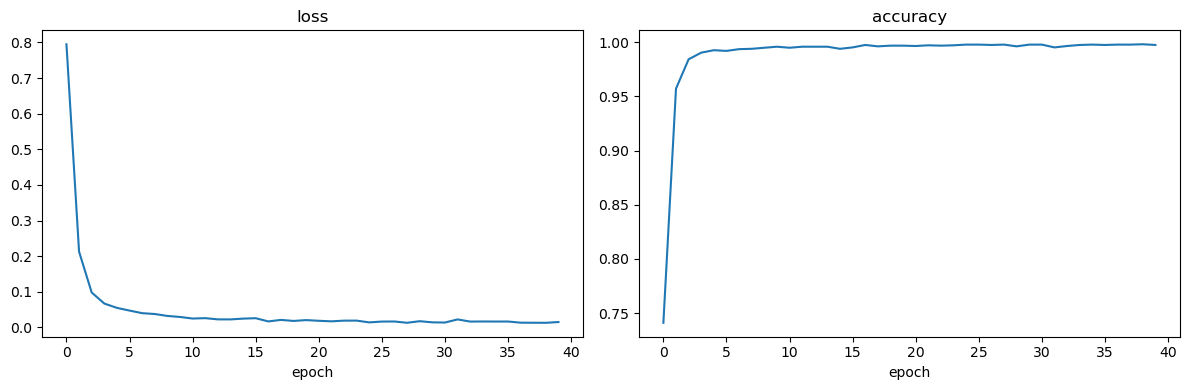

In [26]:
def vis(history, key):
    x = np.arange(0, training_epochs)
    y = list(history.history[key])
    plt.plot(x, y)
    plt.xlabel('epoch')
    plt.title(key)
    
def plot_history(history):
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx, key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()
    
plot_history(history)

## 🎈 모델 검증

In [36]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss:', results[0])
print('test accuracy:', results[1])


# Evaluate on test data
7/7 [==============================] - 1s 40ms/step - loss: 0.0220 - accuracy: 0.9961
test loss: 0.022000396624207497
test accuracy: 0.9961340427398682


## 🎈 예측

In [40]:
root_path = "../data/tmp_test_wavs/"
# test_path = root_path + "CC_04_9949_0001.wav"
# test_path = root + "HH_08_0002_0004.wav"
# test_path = root + "KK_04_0001_0001.wav"
test_path = root + "SD_16_0001_0003.wav"

test = np.array(extract_feature(test_path))
test = tf.reshape(test, [-1, n_row, n_columns, n_channels])

predict = model.predict(test, batch_size=128)[0]
print(test_path," 결과:", code2drum[np.argmax(predict)])

file name : ../data/tmp_test_wavs/SD_16_0001_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
1/1 [==============================] - 0s 21ms/step
../data/tmp_test_wavs/SD_16_0001_0003.wav  결과: SD
